In [16]:
import os
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

from params import params_cae, params_snn, params_train
import utils_ext
import network
import sae
from train_eval import train_fn, evaluate

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

# Define useful variables
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64

In [17]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

### Load train, validation and test dataset and create Data Loader

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"\nShape of each element in the dataloader: {x.shape}\n")
print(f"Number of elements in train set: {len(train_dataset)}.")
print(f"Number of elements in valid set:  {len(val_dataset)}.")
print(f"Number of elements in test set:   {len(test_dataset)}.")

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])

Number of elements in train set: 1424.
Number of elements in valid set:  232.
Number of elements in test set:   232.


The CIR has shape ($2$, $W$, $R$, $K$), where:

- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $W$ is the number of windows, in this case: $W=232$;
- $R$ is the number of range bins, in this case: $R=10$;
- $K$ is the length of each windows, in this case: $K=64$.

### Plot some examples

In [33]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

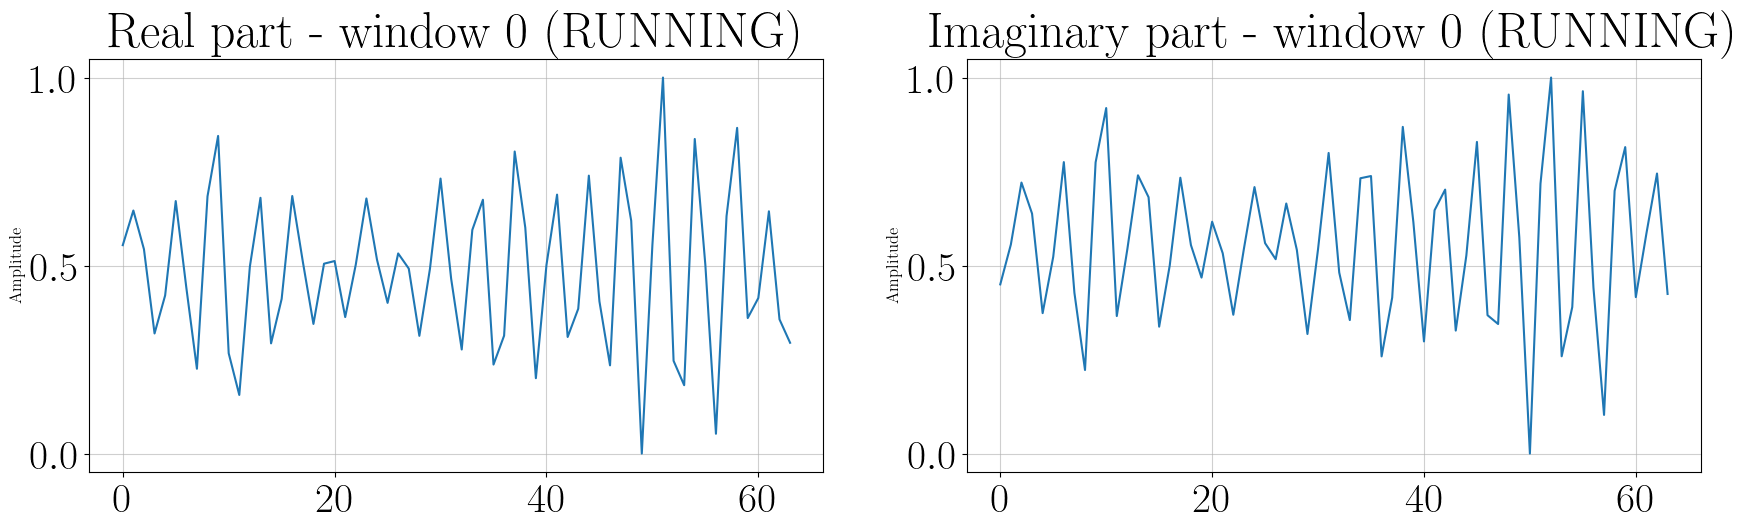

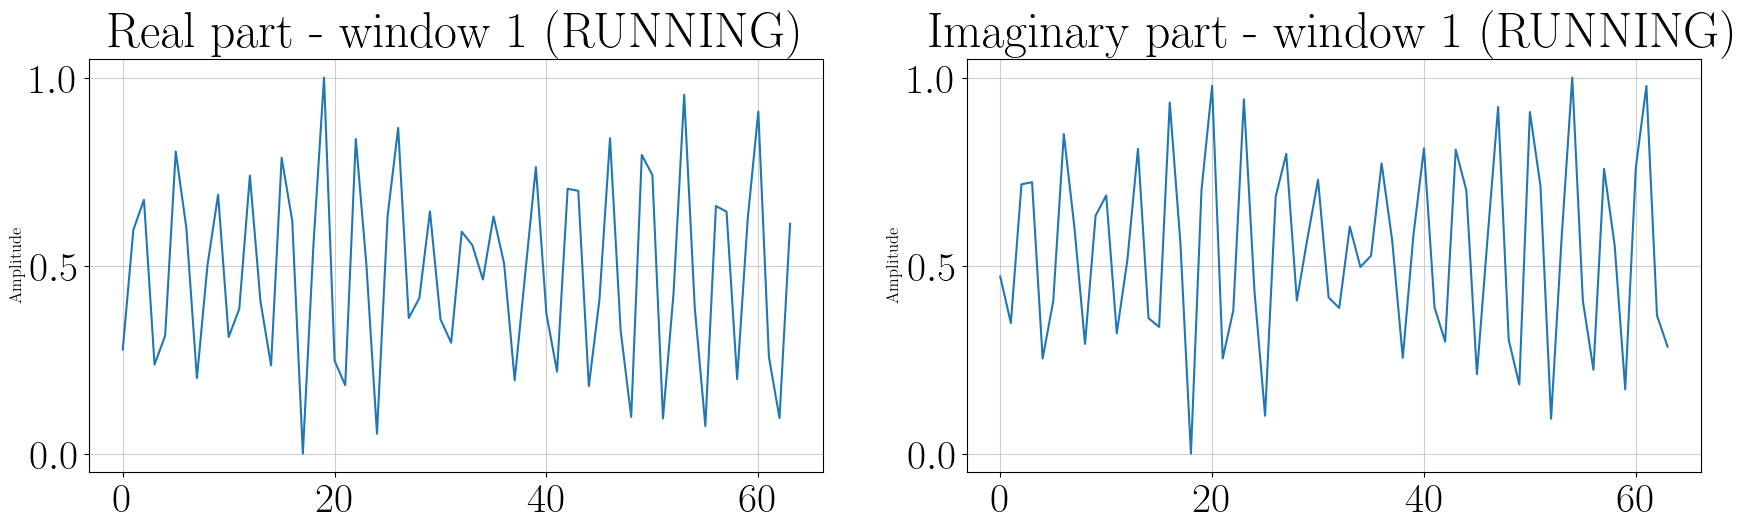

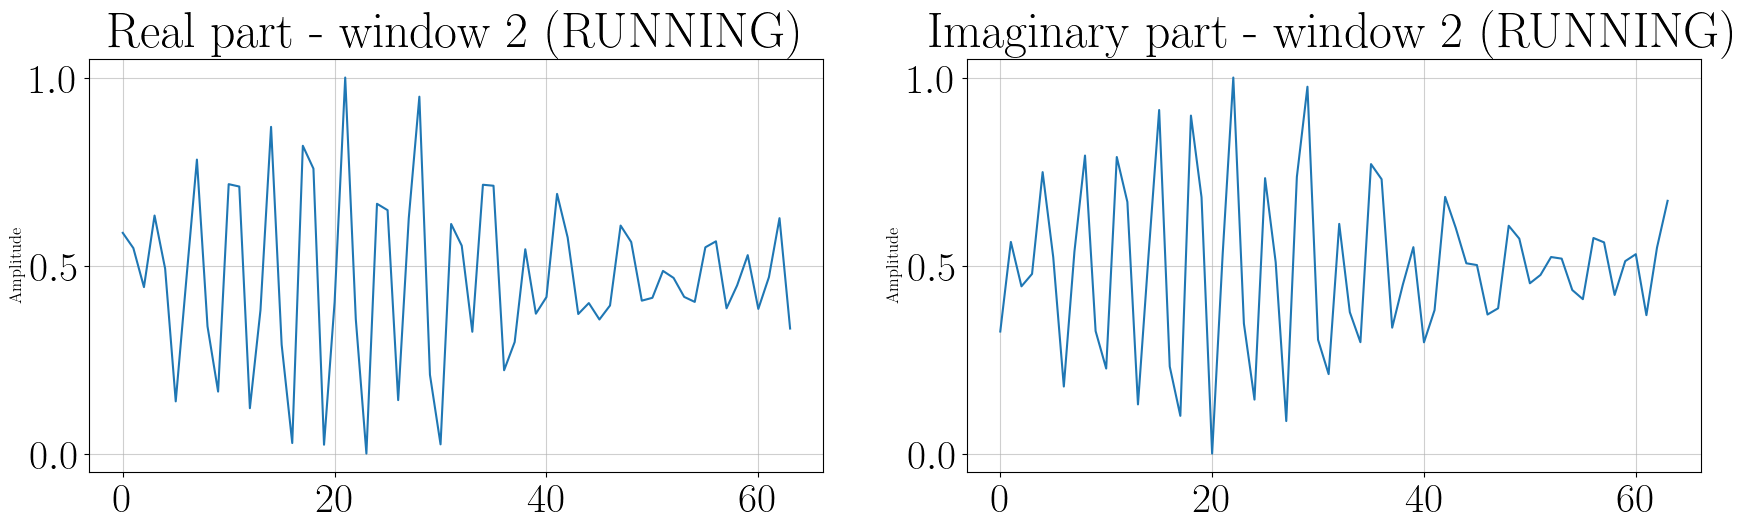

In [37]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

### Model definition

In [38]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        return encoded, decoded, clss

### Train with optimized hyperparams

In [4]:
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = './model_opt_2.pt')


Epoch 1 - loss: 0.4153 | acc: 0.4708 | val_loss: 0.4535 | val_acc: 0.4659
Epoch 2 - loss: 0.2961 | acc: 0.705 | val_loss: 0.2951 | val_acc: 0.6136
Epoch 3 - loss: 0.2493 | acc: 0.7627 | val_loss: 0.2461 | val_acc: 0.6705
Epoch 4 - loss: 0.2509 | acc: 0.7401 | val_loss: 0.2682 | val_acc: 0.5909
Epoch 5 - loss: 0.2349 | acc: 0.7883 | val_loss: 0.2257 | val_acc: 0.7841
Epoch 6 - loss: 0.2283 | acc: 0.7817 | val_loss: 0.2525 | val_acc: 0.6818
Epoch 7 - loss: 0.2126 | acc: 0.8129 | val_loss: 0.2482 | val_acc: 0.6818
Epoch 8 - loss: 0.2029 | acc: 0.8364 | val_loss: 0.2091 | val_acc: 0.7614
Epoch 9 - loss: 0.2069 | acc: 0.8223 | val_loss: 0.2115 | val_acc: 0.7614
Epoch 10 - loss: 0.2024 | acc: 0.8437 | val_loss: 0.3063 | val_acc: 0.6818
Epoch 11 - loss: 0.2049 | acc: 0.8567 | val_loss: 0.229 | val_acc: 0.7955
Epoch 12 - loss: 0.1817 | acc: 0.8768 | val_loss: 0.2241 | val_acc: 0.7841
Epoch 13 - loss: 0.1797 | acc: 0.8919 | val_loss: 0.2572 | val_acc: 0.7386
Epoch 14 - loss: 0.1723 | acc: 0.898

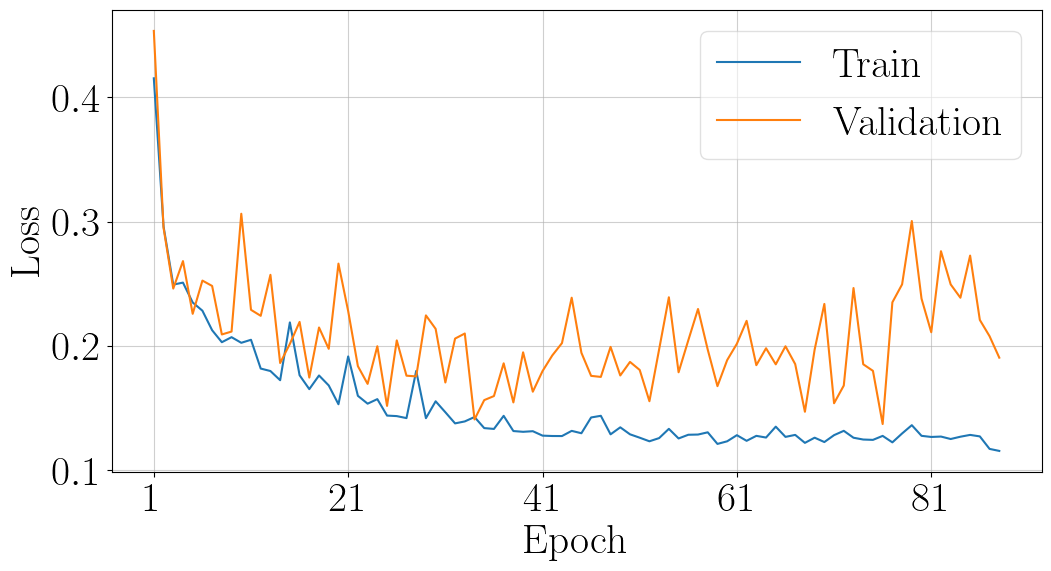

In [48]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_loss.png", bbox_inches='tight')
plt.show()

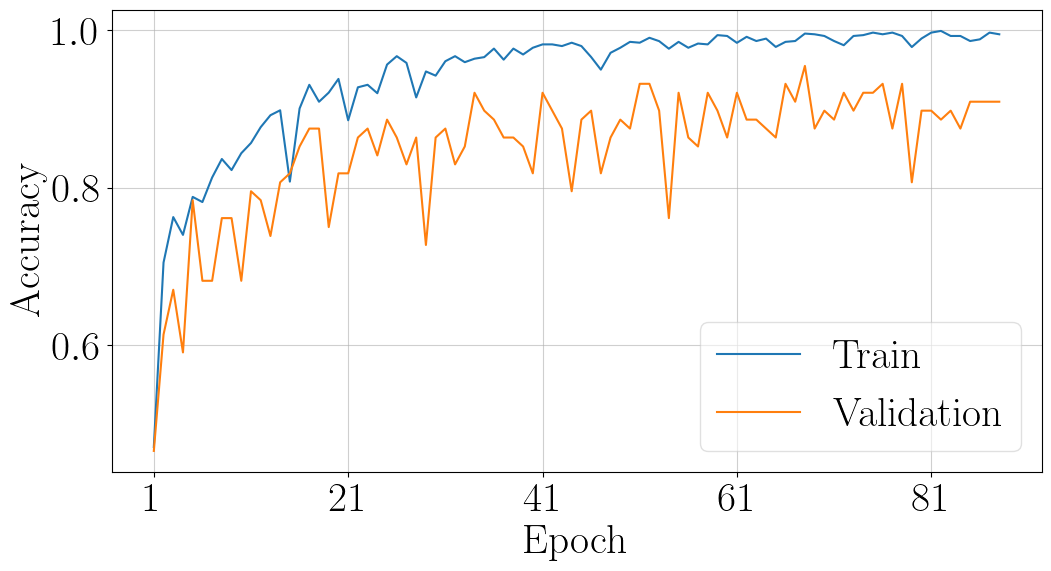

In [51]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_acc.png", bbox_inches='tight')
plt.show()

### Results on test set

In [39]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [42]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, out_dec="rate", 
                                    avg_type='macro', verbose=False)

AVERAGE TYPE: macro

Accuracy: 0.9698
Precision: 0.9653
Recall: 0.9533
F1 score: 0.9572


In [44]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, out_dec="rate", 
                                    avg_type='weighted', verbose=True)

AVERAGE TYPE: weighted

Accuracy: 0.9533
Precision: 0.9716
Recall: 0.9698
F1 score: 0.9696

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.98      0.98      0.98       125
     RUNNING       0.98      0.98      0.98        44
     SITTING       0.90      1.00      0.95        36
       HANDS       1.00      0.85      0.92        27

    accuracy                           0.97       232
   macro avg       0.97      0.95      0.96       232
weighted avg       0.97      0.97      0.97       232



### Plot the confusion matrix

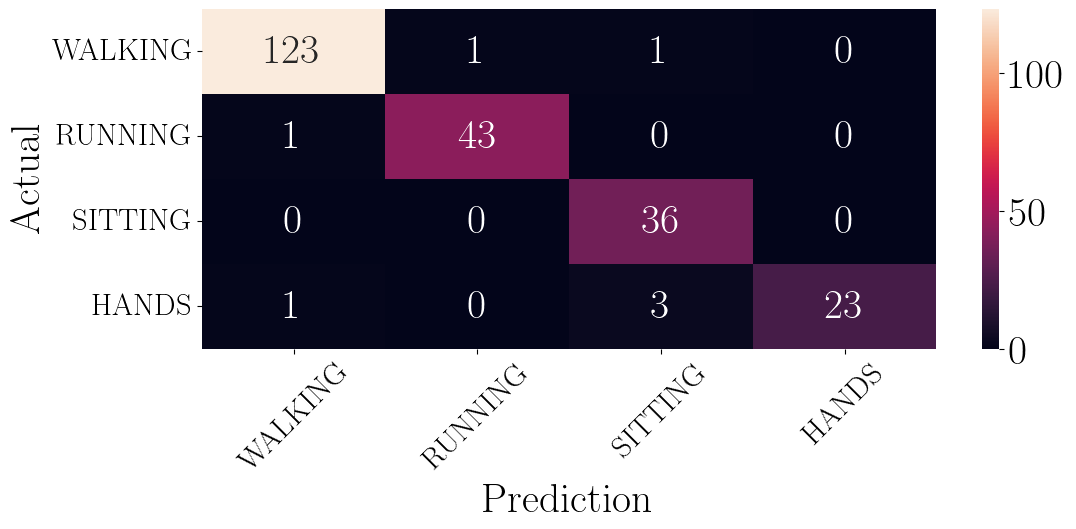

In [45]:
sns.heatmap(conf_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/confusion_mx_macro.pdf", bbox_inches='tight')
plt.show()

## Encoding CAE vs. LIF

In [47]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [21]:
hidden_neurons_sae = [16, 32, 128]
train_loss_ls, val_loss_ls = [], []
train_acc_ls, val_acc_ls = [], []

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for hidd in hidden_neurons_sae:

    autoencoder = sae.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = hidd,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)
    
    net = LSE_1(autoencoder, classifier).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = None)

    train_loss_ls.append(train_loss)
    val_loss_ls.append(val_loss)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)

Epoch 1 - loss: 0.4281 | acc: 0.3817 | val_loss: 0.2742 | val_acc: 0.4886
Epoch 2 - loss: 0.2707 | acc: 0.3724 | val_loss: 0.2676 | val_acc: 0.5
Epoch 3 - loss: 0.2701 | acc: 0.3884 | val_loss: 0.2641 | val_acc: 0.5114
Epoch 4 - loss: 0.2701 | acc: 0.3919 | val_loss: 0.2703 | val_acc: 0.4659
Epoch 5 - loss: 0.2745 | acc: 0.3794 | val_loss: 0.2714 | val_acc: 0.4659
Epoch 6 - loss: 0.268 | acc: 0.3819 | val_loss: 0.2786 | val_acc: 0.3523
Epoch 7 - loss: 0.2641 | acc: 0.3767 | val_loss: 0.2593 | val_acc: 0.4432
Epoch 8 - loss: 0.252 | acc: 0.3858 | val_loss: 0.2538 | val_acc: 0.4318
Epoch 9 - loss: 0.2474 | acc: 0.4061 | val_loss: 0.2408 | val_acc: 0.5
Epoch 10 - loss: 0.2446 | acc: 0.4232 | val_loss: 0.2512 | val_acc: 0.4432
Epoch 11 - loss: 0.2386 | acc: 0.4524 | val_loss: 0.2375 | val_acc: 0.4091
Epoch 12 - loss: 0.2389 | acc: 0.4684 | val_loss: 0.2373 | val_acc: 0.4659
Epoch 13 - loss: 0.2225 | acc: 0.4973 | val_loss: 0.2059 | val_acc: 0.5568
Epoch 14 - loss: 0.2093 | acc: 0.5668 | va

[]

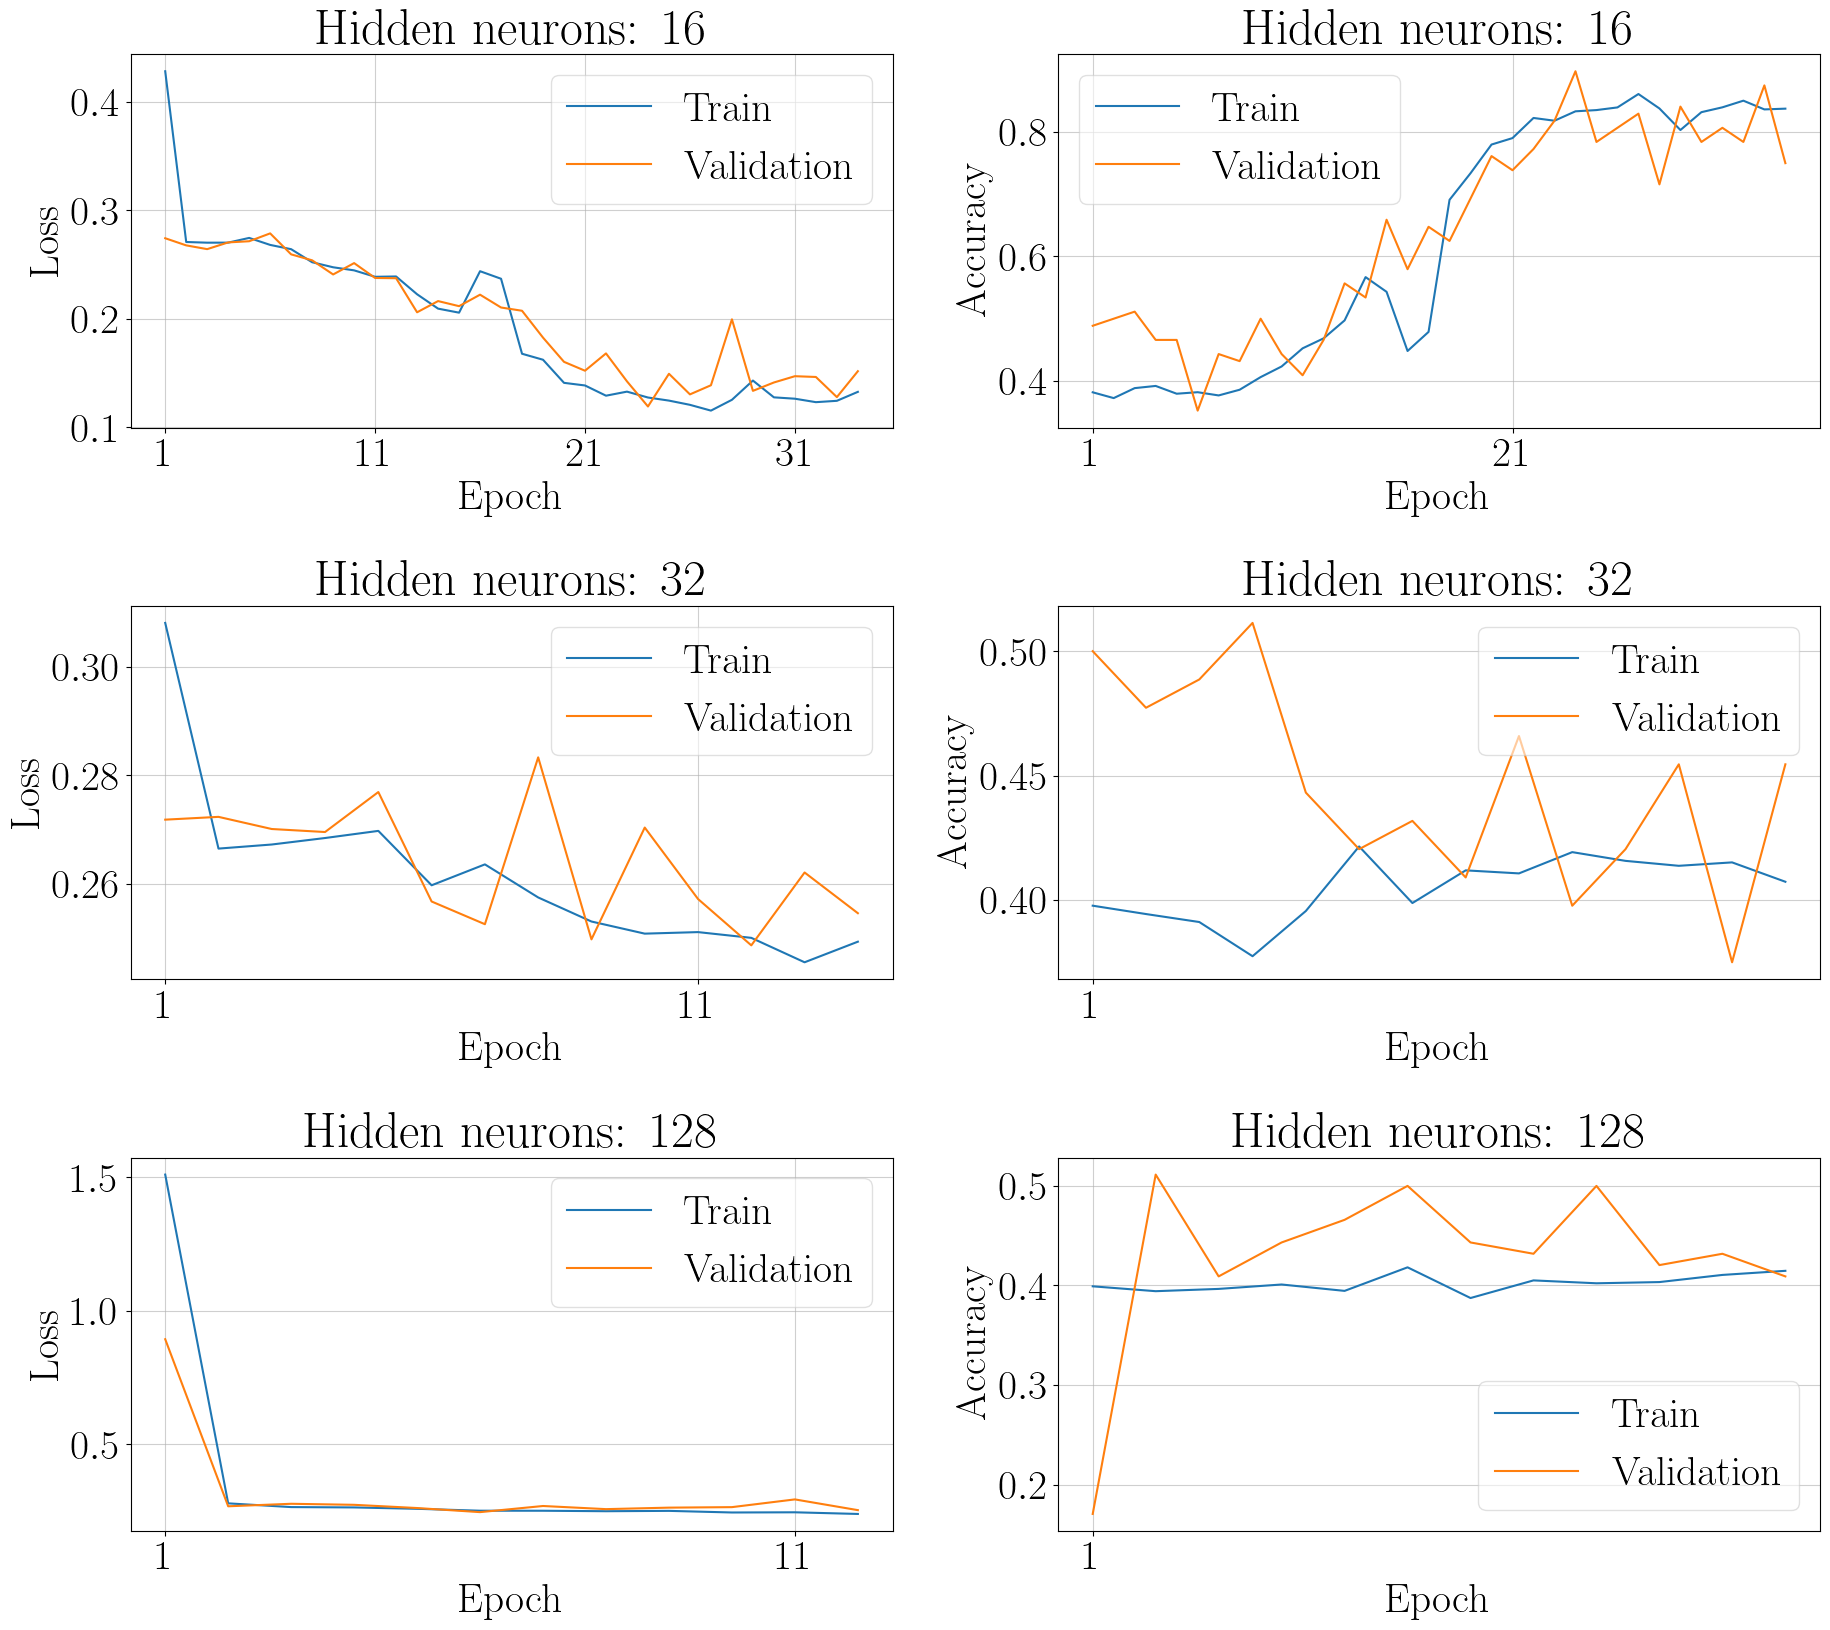

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(19,17))

for i in range(len(hidden_neurons_sae)):
    train_loss, val_loss = train_loss_ls[i], val_loss_ls[i]
    train_acc,  val_acc = train_acc_ls[i], val_acc_ls[i]

    axes[i,0].plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
    axes[i,0].plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
    axes[i,0].grid()
    axes[i,0].set_xlabel("Epoch")
    axes[i,0].set_ylabel("Loss")
    axes[i,0].set_xticks(np.arange(1, len(train_loss), 10))
    axes[i,0].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,0].legend()

    axes[i,1].plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
    axes[i,1].plot(np.arange(1, len(val_acc)+1), val_acc, label='Validation')
    axes[i,1].grid()
    axes[i,1].set_xlabel("Epoch")
    axes[i,1].set_ylabel("Accuracy")
    axes[i,1].set_xticks(np.arange(1, len(train_acc), 20))
    axes[i,1].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,1].legend()

plt.tight_layout()
plt.plot()


In [25]:
autoencoder = sae.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = 16,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc = train_fn(
                                                model = net, 
                                                train = train_loader, 
                                                valid = val_loader,
                                                loss_fn_cae = params_cae['loss_fn'], 
                                                out_dec = params_snn['output_dec'],
                                                optimizer = optimizer, 
                                                acc_steps = params_train['acc_steps'],
                                                alpha = params_train['alpha'], 
                                                beta = params_train['beta'], 
                                                Lambda = params_train['lambda_reg'], 
                                                epochs = params_train['epochs'], 
                                                patience = params_train['patience'], 
                                                path = 'models/model_sae2.pt')

Epoch 1 - loss: 0.2682 | acc: 0.3977 | val_loss: 0.2717 | val_acc: 0.5114
Epoch 2 - loss: 0.2676 | acc: 0.3977 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 3 - loss: 0.2664 | acc: 0.3979 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 4 - loss: 0.264 | acc: 0.3977 | val_loss: 0.2448 | val_acc: 0.5114
Epoch 5 - loss: 0.2645 | acc: 0.398 | val_loss: 0.2696 | val_acc: 0.5114
Epoch 6 - loss: 0.2568 | acc: 0.3976 | val_loss: 0.2403 | val_acc: 0.5114
Epoch 7 - loss: 0.2416 | acc: 0.4266 | val_loss: 0.2267 | val_acc: 0.5227
Epoch 8 - loss: 0.2326 | acc: 0.5005 | val_loss: 0.2475 | val_acc: 0.4545
Epoch 9 - loss: 0.1804 | acc: 0.6024 | val_loss: 0.1924 | val_acc: 0.5682
Epoch 10 - loss: 0.185 | acc: 0.5975 | val_loss: 0.1746 | val_acc: 0.5455
Epoch 11 - loss: 0.1629 | acc: 0.6339 | val_loss: 0.1643 | val_acc: 0.6023
Epoch 12 - loss: 0.1513 | acc: 0.6705 | val_loss: 0.1697 | val_acc: 0.6364
Epoch 13 - loss: 0.15 | acc: 0.6803 | val_loss: 0.1773 | val_acc: 0.5909
Epoch 14 - loss: 0.1492 | acc: 0.6906 |

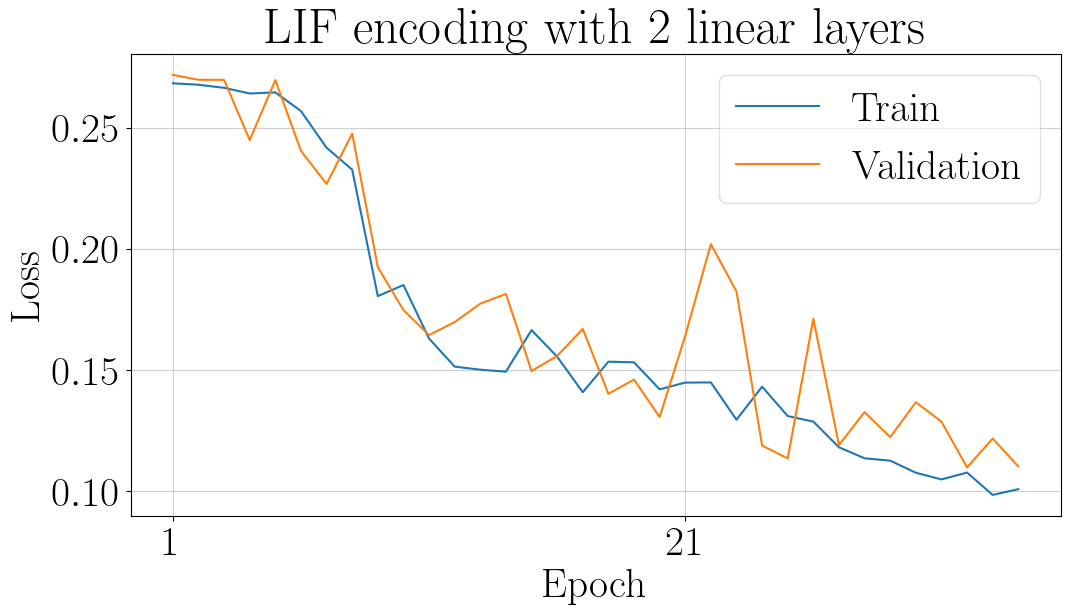

In [26]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LIF encoding with 2 linear layers")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_loss_1.png", bbox_inches='tight')
plt.show()

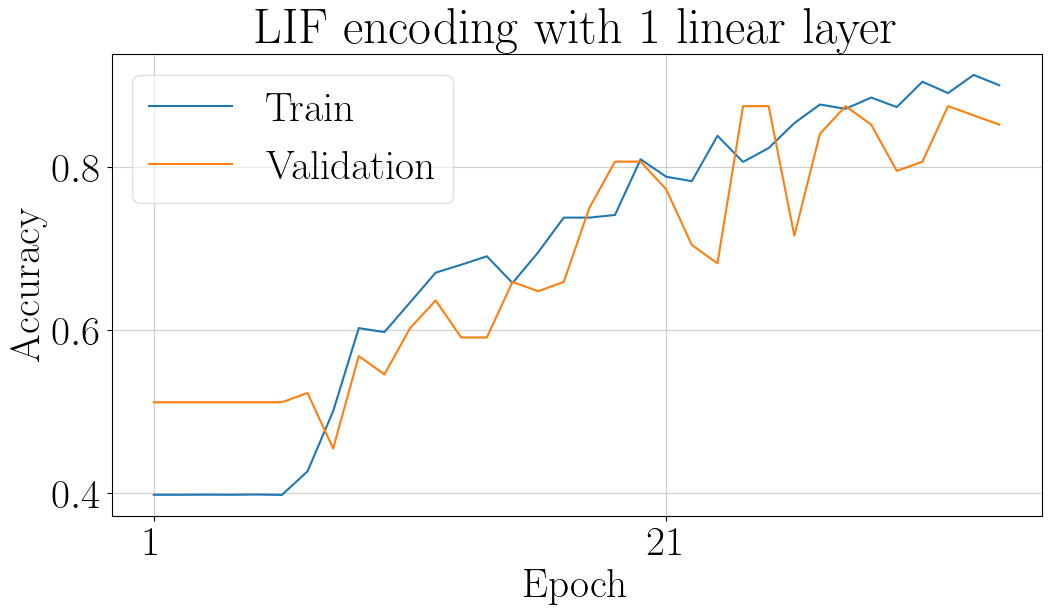

In [27]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LIF encoding with 1 linear layer")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_acc.png", bbox_inches='tight')
plt.show()

In [48]:
path = "./models/model_sae2.pt"
autoencoder = sae.sae_lin2(
                        input_dim = 64, 
                        hidden_dim = 16,
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE_1(
  (autoencoder): sae_lin2(
    (enc1): Linear(in_features=64, out_features=16, bias=True)
    (lif_enc1): Leaky()
    (enc2): Linear(in_features=16, out_features=64, bias=True)
    (lif_code): Leaky()
    (dec1): Linear(in_features=64, out_features=16, bias=True)
    (lif_dec1): Leaky()
    (dec2): Linear(in_features=16, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [49]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, 
                                        out_dec="rate", 
                                        avg_type='macro',
                                        verbose=False)

acc_w, prec_w, rec_w, f1_w, conf_mx_w = evaluate(net, test_loader, 
                                            out_dec="rate", 
                                            avg_type='weighted')

AVERAGE TYPE: macro

Accuracy: 0.8534
Precision: 0.8615
Recall: 0.7848
F1 score: 0.7975
AVERAGE TYPE: weighted

Accuracy: 0.7848
Precision: 0.8678
Recall: 0.8534
F1 score: 0.8472

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.89      0.94      0.92       125
     RUNNING       0.84      0.70      0.77        44
     SITTING       0.71      0.97      0.82        36
       HANDS       1.00      0.52      0.68        27

    accuracy                           0.85       232
   macro avg       0.86      0.78      0.80       232
weighted avg       0.87      0.85      0.85       232



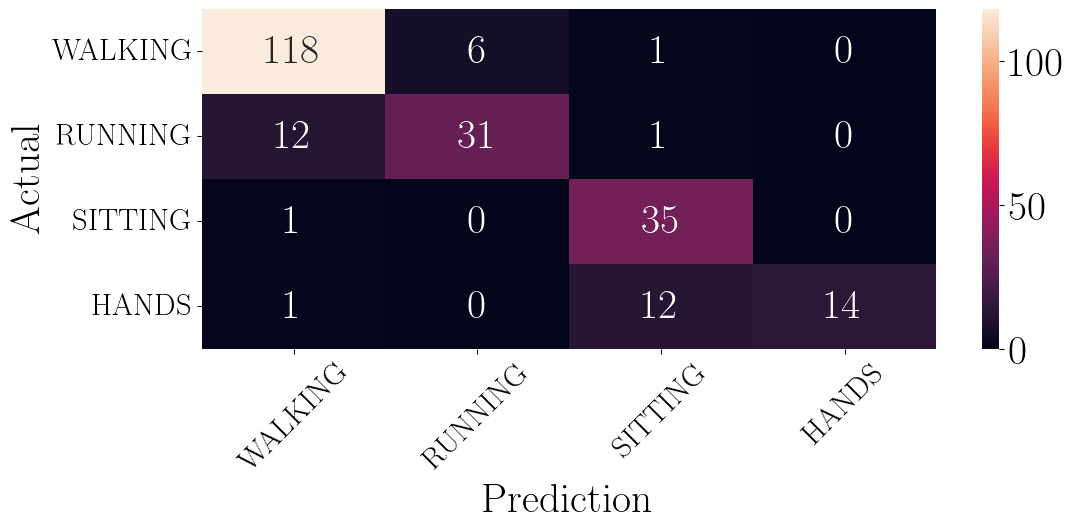

In [50]:
sns.heatmap(conf_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/confusion_mx_macro_sae_lin.png", bbox_inches='tight')
plt.show()

## Encoding capacity

In [ ]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [52]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [53]:
path = "./models/model_sae1.pt"
autoencoder = sae.sae_lin(
                        input_dim = 64, 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net_1 = LSE_1(autoencoder, classifier).to(device)
net_1.load_state_dict(torch.load(path))
net_1.eval()

LSE_1(
  (autoencoder): sae_lin(
    (encoder): Linear(in_features=64, out_features=64, bias=True)
    (lif_code): Leaky()
    (decoder): Linear(in_features=64, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [54]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_sae = 0, 0
sparsity_cae, sparsity_sae = [], [] 
shape_prod = 2*232*64*10

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            encoded, decoded, spk_out = net(X.float())
            encoded1, decoded1, spk_out1 = net_1(X.float())

            loss_cae += loss_fn(decoded, X.float())
            loss_sae += loss_fn(decoded1, X.float())

            sparsity_cae.append((1-torch.sum(abs(encoded))/shape_prod).item())

            sparsity_sae.append((1-torch.sum(abs(encoded1))/shape_prod).item())
            
        loss_cae = loss_cae / len(test_loader)
        loss_sae = loss_sae / len(test_loader)

print(f"Reconstruction error of CAE: {round(loss_cae.item(), 4)}")
print(f"Reconstruction error of SAE: {round(loss_sae.item(), 4)}\n")
print(f"Average sparsity of CAE encoding: {round(np.mean(sparsity_cae), 4)}")
print(f"Average sparsity of SAE encoding: {round(np.mean(sparsity_sae), 4)}")

Reconstruction error of CAE: 0.0194
Reconstruction error of SAE: 0.0571

Average sparsity of CAE encoding: 0.7261
Average sparsity of SAE encoding: 0.9678


### Number of trainable parameters and weight of the model

In [55]:
print(f"# of trainable parameters of CAE: {utils_ext.count_params(net)}")
print(f"# of trainable parameters of SAE: {utils_ext.count_params(net_1)}\n")
print(f"Model size in MB of CAE: {utils_ext.model_size_in_mb(net)} MB")
print(f"Model size in MB of SAE: {utils_ext.model_size_in_mb(net_1)} MB")

# of trainable parameters of CAE: 343380
# of trainable parameters of SAE: 181256

Model size in MB of CAE: 1.31 MB
Model size in MB of SAE: 0.69 MB
